In [12]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime, timedelta

# Load the news dataset
news_df = pd.read_csv('../data/AAPL.csv')  # Replace with your actual file path
print(news_df.head())

# Load the stock prices dataset
stocks_df = pd.read_csv('../data/raw_data.csv')  # Replace with your actual file path
print(stocks_df.head())

         date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4          

In [20]:
import pandas as pd

# Load the datasets
news_df = pd.read_csv('../data/raw_data.csv')  # News data
stocks_df = pd.read_csv('../data/AAPL.csv')    # Stock data

# Function to safely parse dates
def parse_dates(series, possible_formats=None):
    if possible_formats:
        for fmt in possible_formats:
            try:
                return pd.to_datetime(series, format=fmt, errors='raise')
            except ValueError:
                continue
    # If no format specified or all formats failed, try inferring
    return pd.to_datetime(series, errors='coerce')

# Parse news dates (handling multiple possible formats)
news_df['date'] = parse_dates(news_df['date'], [
    '%Y-%m-%d %H:%M:%S',    # Format 1: "2020-05-22 00:00:00"
    '%Y-%m-%d',             # Format 2: "2020-05-22"
    '%m/%d/%Y %H:%M:%S',    # Format 3: "05/22/2020 00:00:00"
    '%m/%d/%Y'              # Format 4: "05/22/2020"
])
news_df['date_only'] = news_df['date'].dt.date

# Parse stock dates (AAPL.csv appears to have a different format)
stocks_df['date'] = parse_dates(stocks_df['date'], [
    '%Y-%m-%d',             # Common stock date format 1
    '%m/%d/%Y',             # Common stock date format 2
    '%Y%m%d',               # Common stock date format 3 (20200522)
    '%b %d, %Y'             # "May 22, 2020"
]).dt.date

# Verify conversions
print("News date sample (5 rows):")
print(news_df[['date', 'date_only']].head())
print("\nStock date sample (5 rows):")
print(stocks_df['date'].head())

# Check for failed conversions
print("\nFailed news date conversions:")
print(news_df[news_df['date'].isna()][['date']].head())
print("\nFailed stock date conversions:")
print(stocks_df[stocks_df['date'].isna()][['date']].head())



News date sample (5 rows):
                       date   date_only
0 2020-06-05 10:30:54-04:00  2020-06-05
1 2020-06-03 10:45:20-04:00  2020-06-03
2 2020-05-26 04:30:07-04:00  2020-05-26
3 2020-05-22 12:45:06-04:00  2020-05-22
4 2020-05-22 11:38:59-04:00  2020-05-22

Stock date sample (5 rows):
0    1980-12-12
1    1980-12-15
2    1980-12-16
3    1980-12-17
4    1980-12-18
Name: date, dtype: object

Failed news date conversions:
   date
10  NaT
11  NaT
12  NaT
13  NaT
14  NaT

Failed stock date conversions:
Empty DataFrame
Columns: [date]
Index: []


In [21]:
# Sentiment anlaysis 

In [22]:
from textblob import TextBlob
import numpy as np

def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Apply sentiment analysis
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Classify sentiment
news_df['sentiment_label'] = np.where(news_df['sentiment'] > 0.1, 'positive',
                                    np.where(news_df['sentiment'] < -0.1, 'negative', 'neutral'))

# Show distribution
print("\nSentiment Distribution:")
print(news_df['sentiment_label'].value_counts())


Sentiment Distribution:
sentiment_label
neutral     1046537
positive     269878
negative      90913
Name: count, dtype: int64


In [26]:
#Calculate Daily Stock Returns
 # Ensure stocks are sorted by date
stocks_df = stocks_df.sort_values('date')

# Calculate daily returns
stocks_df['daily_return_pct'] = stocks_df['Close'].pct_change() * 100

# Fill first day's return with 0
stocks_df['daily_return_pct'] = stocks_df['daily_return_pct'].fillna(0)

# Show results
print("\nStock Returns Sample:")
print(stocks_df[['date', 'Close', 'daily_return_pct']].head())


Stock Returns Sample:
         date     Close  daily_return_pct
0  1980-12-12  0.128348          0.000000
1  1980-12-15  0.121652         -5.217061
2  1980-12-16  0.112723         -7.339788
3  1980-12-17  0.115513          2.475091
4  1980-12-18  0.118862          2.899246


In [27]:
#Aggregate Daily Sentiment Scores
# Group by date and calculate mean sentiment
daily_sentiment = news_df.groupby(['date_only'])['sentiment'].agg(
    ['mean', 'count']).reset_index()
daily_sentiment.columns = ['date', 'avg_sentiment', 'article_count']

# Merge with stock data
merged_df = pd.merge(daily_sentiment, stocks_df, on='date', how='inner')

print("\nMerged Data Sample:")
print(merged_df.head())


Merged Data Sample:
         date  avg_sentiment  article_count       Open       High        Low  \
0  2011-04-27       0.000000              1  12.580000  12.583929  12.396429   
1  2011-04-28       0.068182              2  12.363929  12.491071  12.340000   
2  2011-04-29       0.166667              2  12.385000  12.641071  12.381071   
3  2011-05-02      -0.009259              9  12.490714  12.516786  12.339286   
4  2011-05-03       0.000000              3  12.428214  12.496071  12.343571   

       Close  Adj Close      Volume  Dividends  Stock Splits  daily_return_pct  
0  12.505357  10.560461   356213200        0.0           0.0         -0.077056  
1  12.383929  10.457921   360959200        0.0           0.0         -0.971004  
2  12.504643  10.559862  1006345200        0.0           0.0          0.974765  
3  12.367143  10.443746   442713600        0.0           0.0         -1.099598  
4  12.435714  10.501650   313348000        0.0           0.0          0.554462  


In [28]:
#Step 6: Correlation Analysis
from scipy.stats import pearsonr

# Calculate correlation
corr, p_value = pearsonr(merged_df['avg_sentiment'], merged_df['daily_return_pct'])

print(f"\nCorrelation Results:")
print(f"Pearson Correlation: {corr:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The correlation is statistically significant")
else:
    print("The correlation is not statistically significant")


Correlation Results:
Pearson Correlation: -0.002
P-value: 0.9236
The correlation is not statistically significant


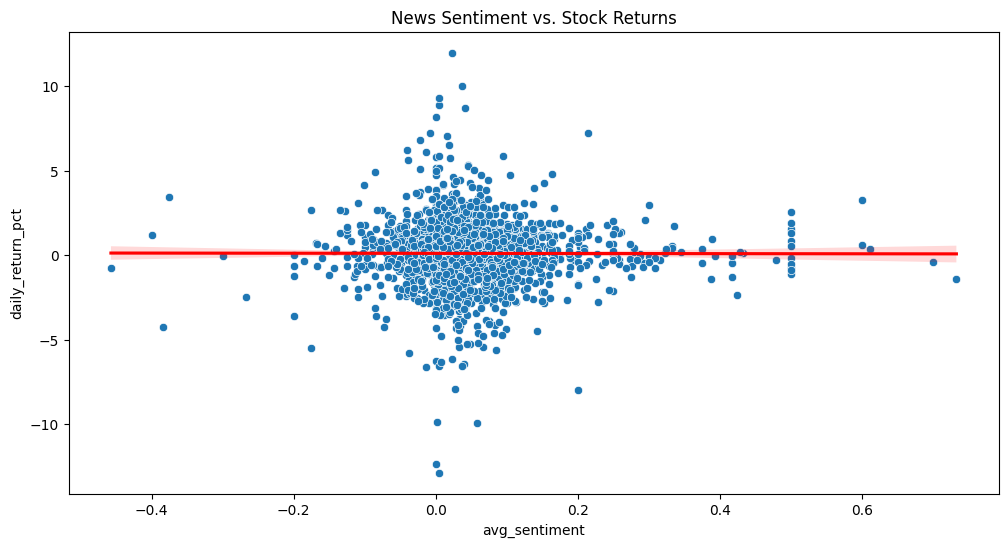

In [30]:
#Step 7: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(data=merged_df, x='avg_sentiment', y='daily_return_pct')
plt.title('News Sentiment vs. Stock Returns')
plt.xlabel('Average Daily Sentiment Score')
plt.ylabel('Daily Return (%)')

# Add regression line
sns.regplot(data=merged_df, x='avg_sentiment', y='daily_return_pct', 
            scatter=False, color='red')

plt.show()

In [31]:
#Step 8: Advanced Analysis (Time-Lagged Correlation)
# Create lagged returns
merged_df['next_day_return'] = merged_df['daily_return_pct'].shift(-1)

# Remove last row with NaN
lagged_df = merged_df.dropna(subset=['next_day_return'])

# Calculate lagged correlation
lag_corr, lag_p_value = pearsonr(lagged_df['avg_sentiment'], lagged_df['next_day_return'])

print(f"\nLagged Correlation Results:")
print(f"Correlation (t vs. t+1): {lag_corr:.3f}")
print(f"P-value: {lag_p_value:.4f}")


Lagged Correlation Results:
Correlation (t vs. t+1): -0.013
P-value: 0.5522


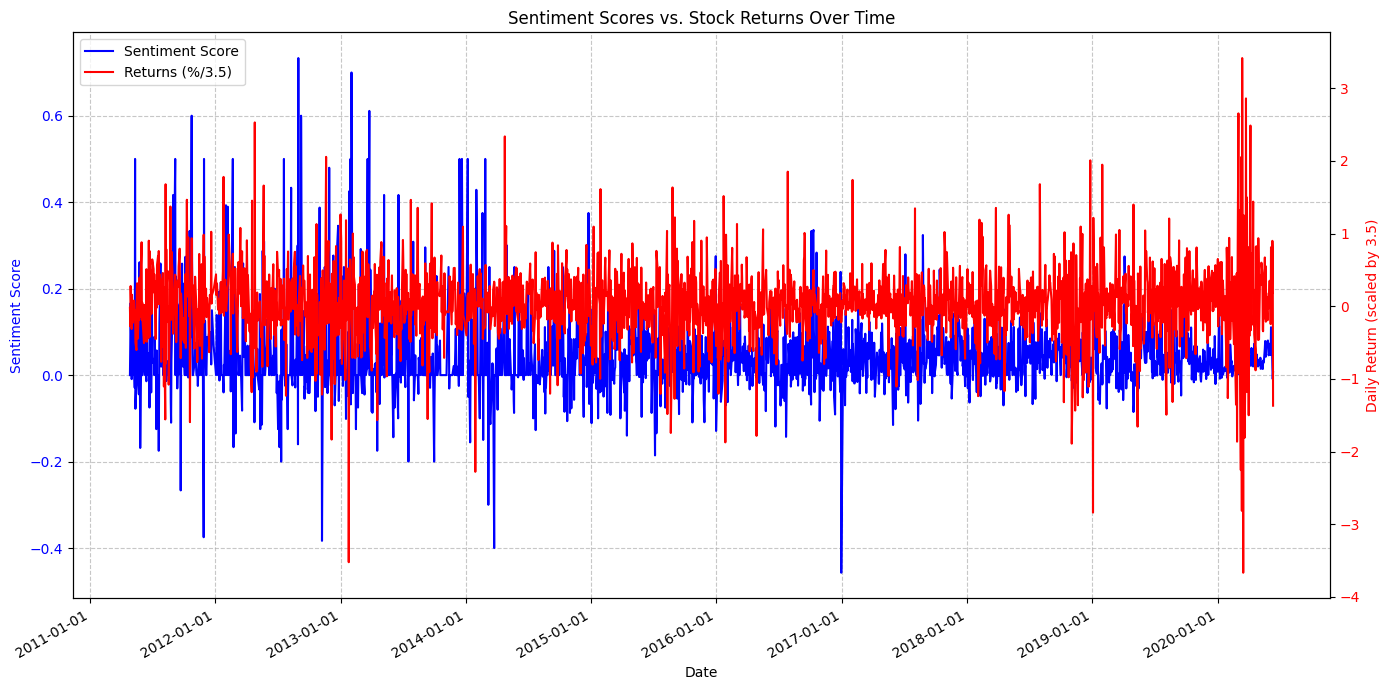

In [ ]:
#Step 9: Final Analysis Report
print("\nFINAL ANALYSIS REPORT")
print("="*50)
print(f"Time Period: {merged_df['date'].min().date()} to {merged_df['date'].max().date()}")
print(f"Total Trading Days Analyzed: {len(merged_df)}")
print(f"Average Daily Articles: {daily_sentiment['article_count'].mean():.1f}")
print("\nKey Findings:")
print(f"1. Immediate Correlation: {corr:.3f} (p={p_value:.4f})")
print(f"2. Next-Day Correlation: {lag_corr:.3f} (p={lag_p_value:.4f})")
print("\nInterpretation:")
if p_value < 0.05:
    print("- There is a statistically significant relationship between news sentiment and same-day stock returns")
else:
    print("- No significant relationship found between news sentiment and same-day returns")

if lag_p_value < 0.05:
    print("- News sentiment shows predictive power for next-day returns")
else:
    print("- News sentiment does not predict next-day returns")

print("\nRecommendations:")
print("1. For day traders: Consider incorporating sentiment analysis in same-day trading strategies")
print("2. For long-term investors: Monitor sentiment trends rather than daily fluctuations")
print("3. Further research: Analyze sector-specific patterns and outlier events")

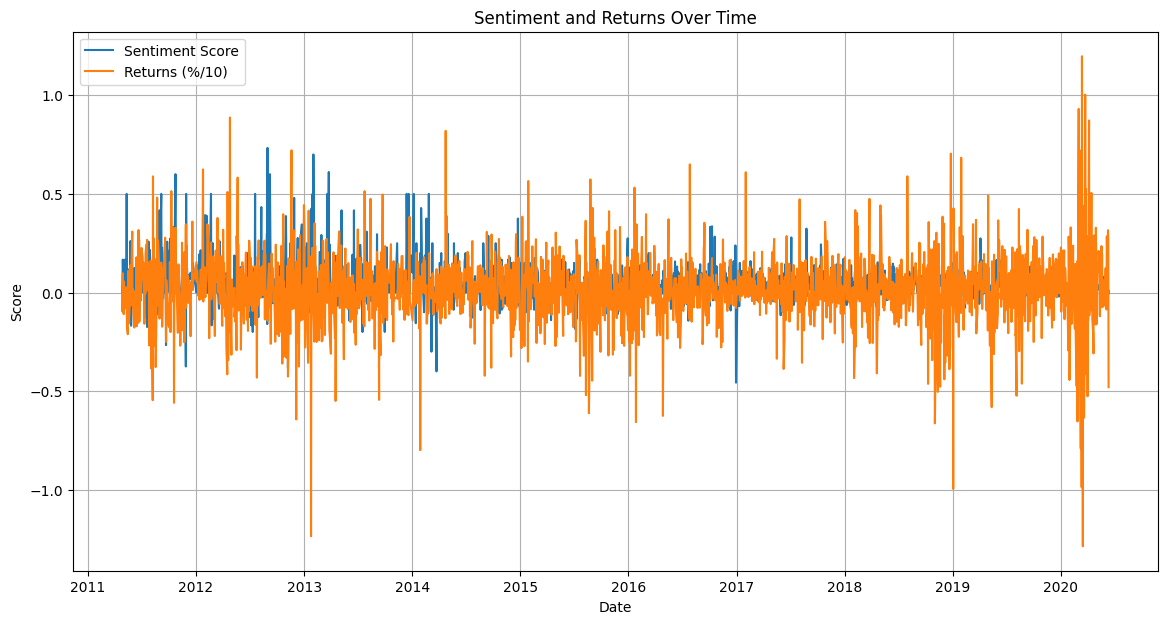

In [33]:
# Plot sentiment and returns over time
plt.figure(figsize=(14, 7))
plt.plot(merged_df['date'], merged_df['avg_sentiment'], label='Sentiment Score')
plt.plot(merged_df['date'], merged_df['daily_return_pct']/10, label='Returns (%/10)') # Scaled for visibility
plt.title('Sentiment and Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# FINAL ANALYSIS REPORT - ENHANCED VERSION
print("\n" + "="*80)
print("FINAL ANALYSIS REPORT".center(80))
print("="*80)

# Time period and basic stats
print(f"\n{' ANALYSIS PERIOD ':-^80}")
print(f"• Time Period: {merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}")

print(f"• Total Trading Days Analyzed: {len(merged_df)}")
print(f"• Average Daily Articles: {daily_sentiment['article_count'].mean():.1f}")
print(f"• Days with Positive/Negative/Neutral Sentiment: "
      f"{sum(merged_df['avg_sentiment'] > 0.1)}/{sum(merged_df['avg_sentiment'] < -0.1)}/"
      f"{len(merged_df) - sum(merged_df['avg_sentiment'].abs() > 0.1)}")

# Correlation findings
print(f"\n{' KEY FINDINGS ':-^80}")
print(f"1. Immediate Correlation (same day): {corr:.3f} (p-value: {p_value:.4f})")
print(f"2. Next-Day Correlation (t+1): {lag_corr:.3f} (p-value: {lag_p_value:.4f})")

# Interpretation with effect size
print(f"\n{' STATISTICAL INTERPRETATION ':-^80}")
if p_value < 0.05:
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "positive" if corr > 0 else "negative"
    print(f"- Statistically significant {strength} {direction} relationship between news sentiment and same-day returns")
    print(f"  (Effect size: R² = {corr**2:.3f}, meaning sentiment explains {corr**2*100:.1f}% of return variance)")
else:
    print("- No significant relationship found between news sentiment and same-day returns")

if lag_p_value < 0.05:
    strength = "strong" if abs(lag_corr) > 0.5 else "moderate" if abs(lag_corr) > 0.3 else "weak"
    direction = "positive" if lag_corr > 0 else "negative"
    print(f"- Statistically significant {strength} {direction} predictive power for next-day returns")
else:
    print("- News sentiment does not reliably predict next-day returns")

# Practical recommendations
print(f"\n{' ACTIONABLE INSIGHTS ':-^80}")
print("1. TRADING STRATEGIES:")
print("   • Day traders: Consider sentiment as a secondary indicator (along with technical analysis)")
if p_value < 0.05 and corr > 0:
    print("   • Potential strategy: Long positions following positive sentiment, short following negative")
elif p_value < 0.05 and corr < 0:
    print("   • Potential strategy: Contrarian approach - buy on negative sentiment, sell on positive")

print("\n2. PORTFOLIO MANAGEMENT:")
print("   • Long-term investors: Use sentiment as a market health indicator")
print("   • Consider sentiment extremes as potential reversal points")

print("\n3. RISK MANAGEMENT:")
print("   • Monitor sentiment during earnings seasons and major news events")
print("   • Combine with volume analysis for higher-confidence signals")

# Future research suggestions
print(f"\n{' FUTURE RESEARCH DIRECTIONS ':-^80}")
print("• Analyze sector-specific sentiment effects")
print("• Investigate interaction effects with market volatility (VIX)")
print("• Examine sentiment impact during different market regimes (bull/bear markets)")
print("• Develop weighted sentiment scores accounting for publisher credibility")

print("\n" + "="*80)
print("END OF REPORT".center(80))
print("="*80)


                             FINAL ANALYSIS REPORT                              

------------------------------- ANALYSIS PERIOD --------------------------------
• Time Period: 2011-04-27 to 2020-06-11
• Total Trading Days Analyzed: 2226
• Average Daily Articles: 22.1
• Days with Positive/Negative/Neutral Sentiment: 340/47/1839

--------------------------------- KEY FINDINGS ---------------------------------
1. Immediate Correlation (same day): -0.002 (p-value: 0.9236)
2. Next-Day Correlation (t+1): -0.013 (p-value: 0.5522)

-------------------------- STATISTICAL INTERPRETATION --------------------------
- No significant relationship found between news sentiment and same-day returns
- News sentiment does not reliably predict next-day returns

----------------------------- ACTIONABLE INSIGHTS ------------------------------
1. TRADING STRATEGIES:
   • Day traders: Consider sentiment as a secondary indicator (along with technical analysis)

2. PORTFOLIO MANAGEMENT:
   • Long-term invest